# TSP - Simone Alberto Peirone (S286886)

**Original template from**

Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [14]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
from numpy.random import randint
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

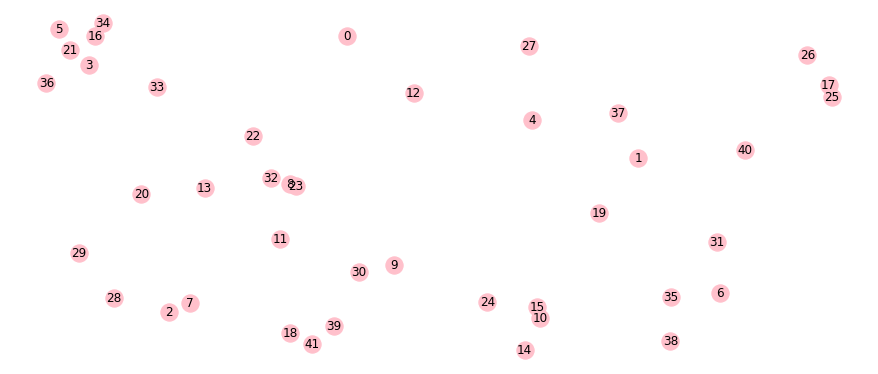

In [16]:
NUM_CITIES = 42

problem = Tsp(NUM_CITIES)
problem.plot()

## Simple Heuristic

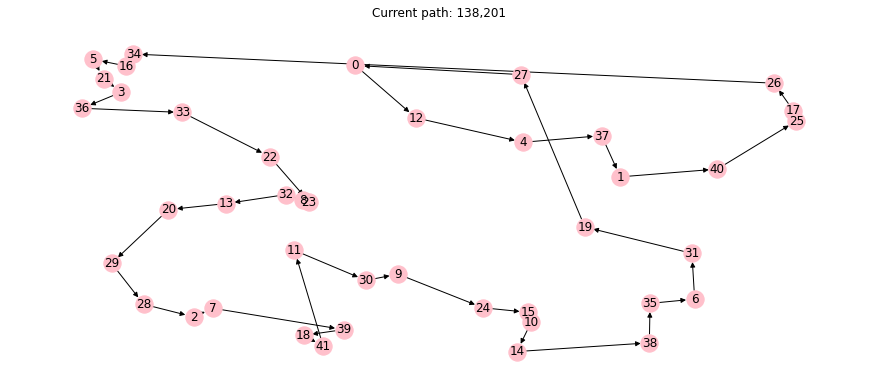

In [17]:
G = nx.Graph()
G.add_nodes_from(problem.graph.nodes())
for n1, n2, _ in sorted([(n1, n2, problem.distance(n1, n2)) for n1, n2 in permutations(problem.graph.nodes(), 2)], key=lambda t: t[2]):
    if len(G.edges(n1)) < 2 and len(G.edges(n2)) < 2:
        G.add_edge(n1, n2)
        try:
            nx.find_cycle(G)
            G.remove_edge(n1, n2)
        except:
            pass

G.add_edge(*[n for n in G if len(G.edges(n))<2])
solution = np.array([0] + [n[0] for n in nx.dfs_successors(G, 0).values()])
problem.plot(solution)

## Random-Mutation Hill Climber

In [18]:
def tweak(solution: np.array, *, pm: float = 1/NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

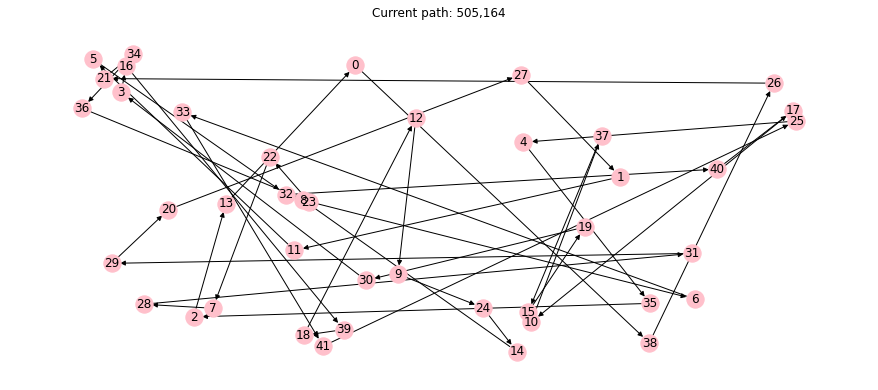

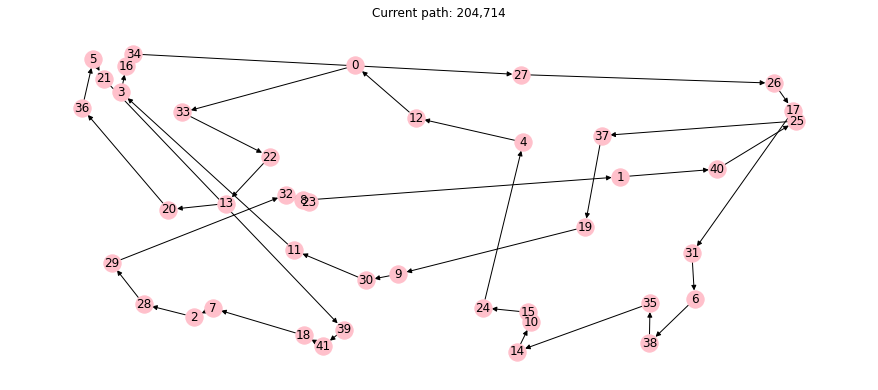

In [19]:
STEADY_STATE = 1000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    new_solution = tweak(solution, pm=.5)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
problem.plot(solution)

# Proposed solution

GA with **Inver Over** recombination and edge swapping mutations. The mutation probability self adapts according to the trend of discovered solutions. If *stuck*, the algorithm randomly restarts the worst portion (lower fitness) of the population.

In [20]:
def inver_over(p1, p2):
    """
    Recombine two solutions using Inver Over crossover
    """
    candidate = np.random.randint(0, len(p1) - 1)
    follower = p2[(np.argwhere(p2 == candidate).flatten()[0] + 1) % len(p2)]
    
    child = np.hstack([
        p1[:min(np.argwhere(p1 == candidate).flatten()[0], np.argwhere(p1 == follower).flatten()[0])],
        candidate,
        follower
    ])
    return np.hstack([child, np.setdiff1d(p1, child, assume_unique=True)])

In [21]:
def cycle_crossover(p1, p2, width=7):
    """
    Recombine two solution using cycle crossover.
    """
    width = np.random.randint(3, width)
    start = np.random.randint(0, p1.size - width)

    child = np.ones(shape=p1.shape, dtype=np.int8) * -1
    child[start:start+width] = p1[start:start+width]
    child[child == -1] = np.setdiff1d(p2, child, assume_unique=True)

    return child

In [22]:
def tweak_invert(solution: np.array, *, p = 4//NUM_CITIES) -> np.array:
    """
    Mutate the input by reversing a subset of itselements
    """
    new_solution = solution.copy()
    selection_mask = np.random.uniform(size=NUM_CITIES) < p
    inverted_selection_mask = np.flip(np.argwhere(selection_mask))

    new_solution[np.argwhere(selection_mask)] = new_solution[inverted_selection_mask]
    
    return new_solution

In [23]:
def tweak_h(solution: np.array) -> np.array:
    """
    Mutate the solution by finding the element with
    the heaviest edges and swapping them.
    """
    new_solution = solution.copy()

    # Compute the distance for all the elements
    distances = np.zeros(shape=new_solution.shape)

    for i in range(new_solution.size):
        distances[i] += problem.distance(new_solution[i], new_solution[(i + 1) % NUM_CITIES])

    i = np.argmax(distances)
    i1, i2 = (i + NUM_CITIES - 1) % NUM_CITIES, (i + 1) % NUM_CITIES
    new_solution[i1], new_solution[i2] = new_solution[i2], new_solution[i1]

    return new_solution

In [24]:
def generate_offspring(population, size, mutation_prob=1//NUM_CITIES):
    """
    Generate an offspring of a given size.
    """
    P1s = randint(0, population.shape[0] // 2, size=size)
    P2s = randint(0, population.shape[0], size=size)

    offspring = np.vstack([
        inver_over(population[a], population[b])
        # cycle_crossover(population[a], population[b])
        for a, b in zip(P1s, P2s)
    ])
    offspring = np.vstack([
        tweak_h(individual) if np.random.uniform() < mutation_prob else individual 
        for individual in offspring
    ])
    offspring_fitness = np.array([problem.evaluate_solution(individual) for individual in offspring])

    return offspring, offspring_fitness

In [25]:
def sort_by_fitness(population, fitness):
    sorted_indices = np.argsort(fitness)
    return population[sorted_indices], fitness[sorted_indices]

Initial solution cost 581940


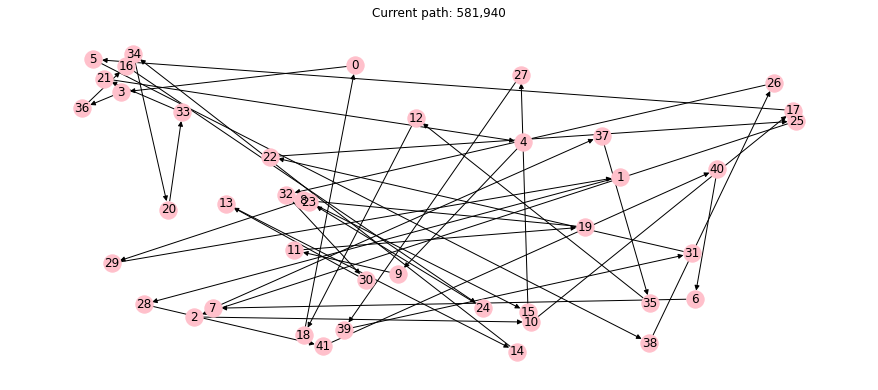

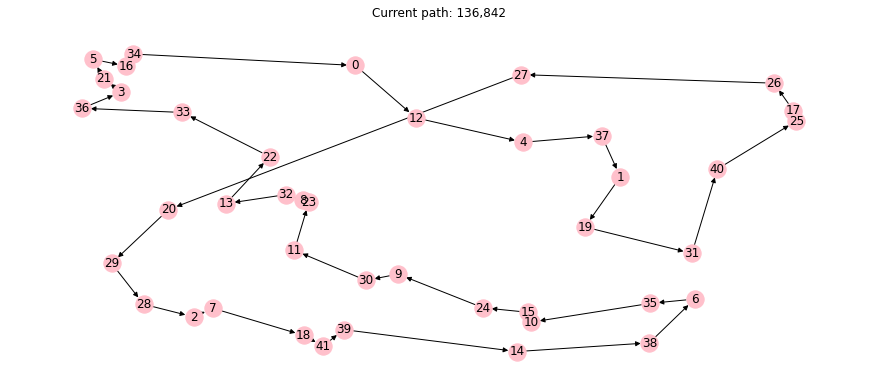

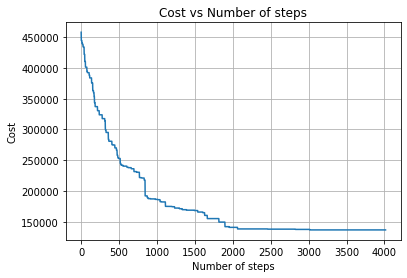

In [28]:
STEADY_STATE = 1000
POP_SIZE = 42
OFFSPRING_SIZE = 8

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)

print(f"Initial solution cost {solution_cost}")
problem.plot(solution)

# Start with an initial population of 4
population = np.vstack([np.random.permutation(solution) for _ in range(4)])
fitness = None

history = [(0, solution_cost)]
history_costs = []

steady_state = 0
step = 0

p = 4 / NUM_CITIES

while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1

    # Compute the fitness for each individual
    if fitness is None:
        # fitness is computed directly only during the first iteration
        # and updated in the following steps
        fitness = np.array([
            problem.evaluate_solution(individual) for individual in population
        ])

    # Sort the individual according to their fitness
    population, fitness = sort_by_fitness(population, fitness)

    # Generate the offspring and pick a solution
    offspring, offspring_fitness = generate_offspring(population, OFFSPRING_SIZE, p)
    new_solution = offspring[np.argmin(offspring_fitness)]

    # Update population and fitness with the offspring
    population, fitness = sort_by_fitness(
        np.vstack([population, offspring]), 
        np.hstack([fitness, offspring_fitness])
    )

    # Keep population size under control by killing 
    # some of the worst individuals
    population = population[:min(POP_SIZE, population.shape[0])]
    fitness = fitness[:min(POP_SIZE, population.shape[0])]

    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
        # Update the mutation probability
        p = np.clip(p - .5 * 1/NUM_CITIES, 0, 1.0)

    if steady_state >= 2 and steady_state % 2 == 0:
        # Select the number of individuals to keep
        n = max(POP_SIZE // 4, POP_SIZE - steady_state // 2)

        population = np.vstack([
            population[:n],
            [np.random.permutation(solution) for _ in range(POP_SIZE - n)]
        ])
        fitness = np.hstack([
            fitness[:n],
            [problem.evaluate_solution(individual) for individual in population[n:]]
        ])

        # Update the mutation probability
        p = np.clip(p + 0.005 * 1/NUM_CITIES, 0, 1.0)

    history_costs.append(solution_cost)

problem.plot(solution)

plt.figure()
plt.title("Cost vs Number of steps")
plt.plot(range(len(history_costs)), history_costs)
plt.xlabel("Number of steps")
plt.ylabel("Cost")
plt.grid()
plt.show()